# Reto: Modelo basado en *deep learning* para la discriminación entre gatos y perros

**Objetivos**:
- Diseñar modelos de redes neuronales profundas (*deep learning*), enfocándose en la clasificación de imágenes de acuerdo a categrías preestablecidas para resolver problemas con relevancia social, permitiendo valor en los diversos sectores.
- Crear modelos de datos *Deep Neural Networks* (DNN) utilizando PyTorch basado en Python; seleccionando el modelo adecuado y analizando la exactitud del modelo, para cumplir lo mejor posible con los requerimientos de la tarea requerida.

## 1. Preprocesamiento de la base de datos

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importando bibliotecas
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pathlib

In [3]:
# Eliminando cualquier archivo que no sea JPG, JPEG, PNG
!find /content/drive/MyDrive/Reto_PyTorch/catsvsdogs -type f ! -name '*.jpg' ! -name '*.jpeg' ! -name '.*png' -delete

In [4]:
# Directorio base
data_dir = pathlib.Path('/content/drive/MyDrive/Reto_PyTorch/catsvsdogs')
conteo_img = len(list(data_dir.glob('*/*')))
print('Total de imágenes a analizar:', conteo_img)

Total de imágenes a analizar: 4895


In [5]:
# Transformaciones
transform = transforms.Compose([
    # Ajustar tamaño de la imagen
    transforms.Resize((224,224)),
    # Transformar a tensor
    transforms.ToTensor(),
])

### 1.2 Normalización de las imágenes

In [ ]:
# Imagenes sin normalizar
dataset = datasets.ImageFolder(data_dir, transform=transform)
loader = DataLoader(dataset,batch_size=64,shuffle=False,num_workers=2)

# Calculando promedio y desviación estándar
mean = 0
std = 0
total_imgs = 0
for images,_ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples,images.size(1),-1) # (batch,canales,pixeles)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_imgs += batch_samples
mean = mean/total_imgs
std = std/total_imgs
print('Promedio:', mean)
print('Desviación estándar:', std)

Promedio: tensor([0.4815, 0.4475, 0.3969])
Desviación estándar: tensor([0.2255, 0.2230, 0.2250])


In [6]:
# Transformación final
transform = transforms.Compose([
    # Ajustar tamaño de la imagen
    transforms.Resize((224,224)),
    # Transformar a tensor
    transforms.ToTensor(),
    # Normalizar
    transforms.Normalize(mean = [0.4815,0.4475,0.3969],
                        std = [0.2255,0.2230,0.2250])
])


## 2. Sets de Entrenamiento y Validación

In [7]:
# Dataset completo desde el directorio establecido
dataset = datasets.ImageFolder(data_dir, transform=transform)

# División: 80% entrenamiento, 20% validación
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

# Batch
batch_size = 32
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_set,batch_size=batch_size,shuffle=False)

# Tamaño de los sets
print(f'Imágenes:',len(dataset))
print(f'Entrenamiento', len(train_set))
print(f'Validación', len(val_set))

Imágenes: 4895
Entrenamiento 3916
Validación 979


## 3. Construcción de la Red Neuronal

In [8]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self,input_size = 224*224*3,output_size = 2):
        super().__init__()
        self.fc1 = nn.Linear(input_size,512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,output_size)

    def forward(self,X):
        X = X.view(X.shape[0],-1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return X

 # Creando el modelo
model = MultiLayerPerceptron()

# Ver la estructura del modelo
print(model)

MultiLayerPerceptron(
  (fc1): Linear(in_features=150528, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
)


In [10]:
# Definiendo pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

# Mover a GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 4. Definición de Funciones Para Entrenamiento y Validación

### 4.1 Función de Entrenamiento

In [18]:
# Función para entrenar
def train(model,train_loader,criterion,optimizer,device):
    # Modelo en modo entrenamiento
    model.train()

    # Mover medole a dispositivo especificado (GPU/CPU)
    model.to(device)

    # Valores para seguir el historial de pérdida y precisión
    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    # Ciclo sobre el set de entrenamiento
    for images,labels in train_loader:
        # Mover a GPU/CPU
        images,labels = images.to(device), labels.to(device)

        # Reiniciar gradiente para prevenir acumulación
        optimizer.zero_grad()

        # Forward pass, obtener predicción
        outputs = model(images)

        # Calcular pérdida
        loss = criterion(outputs,labels)

        # Backward pass
        loss.backward()

        # Actualizar los parametros del modelo
        optimizer.step()

        # Acumulado de la pérdida
        running_loss += loss.item()

        # Obtener probabilidad maximo de la clase predicha
        _, predicted = torch.max(outputs.data,dim = 1)

        # Acumulado de predicciones correctas
        correct_predictions += (predicted == labels).sum().item()

        # Acumulado de muestras
        total_samples += labels.size(0)

    # Promedio de perdida
    avg_loss = running_loss / len(train_loader)

    # Precisión
    accuracy = correct_predictions / total_samples

    # Precisión (%)
    accuracy = 100 * correct_predictions / total_samples

    return avg_loss, accuracy


### 4.2 Validación de la Red *Neuronal*

In [19]:
def validate(model,val_loader,criterion,device):
    # Modelo en modo evaluación
    model.eval()

    # Mover medole a dispositivo especificado (GPU/CPU)
    model.to(device)

    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    # No calcular gradientes
    with torch.no_grad():
        for images,labels in val_loader:
            # Mover a GPU/CPU
            images,labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data,dim = 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = 100*correct_predictions / total_samples

    return avg_loss, accuracy


## 5. Entrenamiento y Validación de la Red Neuronal

### 5.1 Entrenamiento

In [22]:
# Epochs
num_epochs = 20
train_losses, val_losses = [],[]
train_accuracy, val_accuracy = [],[]

# Entrenamiento
for epoch in range(num_epochs):
    train_loss, train_acc = train(model,train_loader,criterion,optimizer,device)
    val_loss, val_acc = validate(model,val_loader,criterion,device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracy.append(train_acc)
    val_accuracy.append(val_acc)

    print(f'Epoch {epoch +1}/{num_epochs}')
    print(f' Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.2f}%')
    print(f' Val loss: {val_loss:.4f} | Val accuracy: {val_acc:.2f}%')


Epoch 1/20
 Train loss: 1.2169 | Train accuracy: 54.80%
 Val loss: 0.8228 | Val accuracy: 54.55%
Epoch 2/20
 Train loss: 0.6979 | Train accuracy: 62.00%
 Val loss: 0.7704 | Val accuracy: 57.41%
Epoch 3/20
 Train loss: 0.6352 | Train accuracy: 66.62%
 Val loss: 0.8254 | Val accuracy: 56.28%
Epoch 4/20
 Train loss: 0.6055 | Train accuracy: 69.31%
 Val loss: 0.8337 | Val accuracy: 57.30%
Epoch 5/20
 Train loss: 0.5693 | Train accuracy: 71.99%
 Val loss: 0.7196 | Val accuracy: 58.73%
Epoch 6/20
 Train loss: 0.5317 | Train accuracy: 73.60%
 Val loss: 0.7525 | Val accuracy: 58.32%
Epoch 7/20
 Train loss: 0.4912 | Train accuracy: 76.61%
 Val loss: 0.8140 | Val accuracy: 61.70%
Epoch 8/20
 Train loss: 0.4498 | Train accuracy: 78.86%
 Val loss: 0.8115 | Val accuracy: 60.57%
Epoch 9/20
 Train loss: 0.4143 | Train accuracy: 82.18%
 Val loss: 0.8323 | Val accuracy: 62.10%
Epoch 10/20
 Train loss: 0.4091 | Train accuracy: 82.38%
 Val loss: 0.9521 | Val accuracy: 58.43%
Epoch 11/20
 Train loss: 0.32

### 5.2 Rendimiento de la Red Neuronal

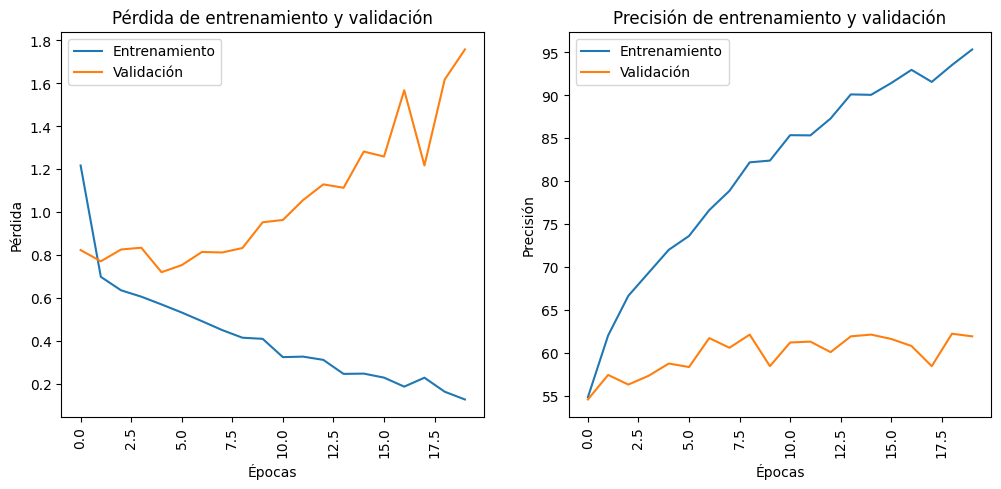

In [23]:
plt.figure(figsize=(12,5))

# Pérdida
plt.subplot(1,2,1)
plt.plot(train_losses,label='Entrenamiento')
plt.plot(val_losses,label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.xticks(rotation=90)
plt.title('Pérdida de entrenamiento y validación')
plt.legend()

# Precisión
plt.subplot(1,2,2)
plt.plot(train_accuracy,label='Entrenamiento')
plt.plot(val_accuracy,label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.xticks(rotation=90)
plt.title('Precisión de entrenamiento y validación')
plt.legend()

plt.show()

## 6. Optimización de la Red Neuronal Inicial

### 6.1 Transformaciones para optimizar la red neuronal

In [43]:
# Transformación final
transform = transforms.Compose([
    # Ajustar tamaño de la imagen
    transforms.Resize((64,64)),
    # Transformar a tensor
    transforms.ToTensor(),
    # Normalizar para que los valores se encuentren entre 0 y 1
    transforms.Normalize(mean = [0.5,0.5,0.5],
                        std = [0.5,0.5,0.5]),
    # Data Augmentation
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10)
])


### 6.2 Sets de Entrenamiento y Validación

In [44]:
# Dataset completo desde el directorio establecido
dataset = datasets.ImageFolder(data_dir, transform=transform)

# División: 80% entrenamiento, 20% validación
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

# Batch
batch_size = 32
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_set,batch_size=batch_size,shuffle=False)

# Tamaño de los sets
print(f'Imágenes:',len(dataset))
print(f'Entrenamiento', len(train_set))
print(f'Validación', len(val_set))

Imágenes: 4895
Entrenamiento 3916
Validación 979


### 6.3 Arquitectura de la Red Neuronal Optimizada

In [46]:
class MultiLayerPerceptron64(nn.Module):
    def __init__(self, input_size=64*64*3, output_size=2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, X):
        X = X.view(X.size(0),-1)
        X = F.relu(self.fc1(X))
        X = self.dropout1(X)
        X = F.relu(self.fc2(X))
        X = self.dropout2(X)
        X = self.fc3(X)
        return X

# Creando modelo
model_2 = MultiLayerPerceptron64()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(),lr=0.0005)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Estructura del modelo
print(model_2)

MultiLayerPerceptron64(
  (fc1): Linear(in_features=12288, out_features=512, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


## 7. Entrenamiento y Validación de la Red Neuronal Optimizada

### 7.1 Entrenamiento

In [47]:
# Entrenamiento
for epoch in range(num_epochs):
    train_loss2, train_acc2 = train(model_2,train_loader,criterion,optimizer,device)
    val_loss2, val_acc2 = validate(model_2,val_loader,criterion,device)

    train_losses.append(train_loss2)
    val_losses.append(val_loss2)
    train_accuracy.append(train_acc2)
    val_accuracy.append(val_acc2)

    print(f'Epoch {epoch +1}/{num_epochs}')
    print(f' Train loss: {train_loss2:.4f} | Train accuracy: {train_acc2:.2f}%')
    print(f' Val loss: {val_loss2:.4f} | Val accuracy: {val_acc2:.2f}%')


Epoch 1/20
 Train loss: 0.7394 | Train accuracy: 54.42%
 Val loss: 0.6907 | Val accuracy: 56.08%
Epoch 2/20
 Train loss: 0.6877 | Train accuracy: 57.53%
 Val loss: 0.6730 | Val accuracy: 57.20%
Epoch 3/20
 Train loss: 0.6658 | Train accuracy: 59.83%
 Val loss: 0.6597 | Val accuracy: 60.57%
Epoch 4/20
 Train loss: 0.6545 | Train accuracy: 60.73%
 Val loss: 0.6467 | Val accuracy: 61.29%
Epoch 5/20
 Train loss: 0.6477 | Train accuracy: 62.36%
 Val loss: 0.6767 | Val accuracy: 57.41%
Epoch 6/20
 Train loss: 0.6414 | Train accuracy: 62.74%
 Val loss: 0.6686 | Val accuracy: 58.84%
Epoch 7/20
 Train loss: 0.6300 | Train accuracy: 63.74%
 Val loss: 0.6538 | Val accuracy: 59.65%
Epoch 8/20
 Train loss: 0.6365 | Train accuracy: 63.71%
 Val loss: 0.6493 | Val accuracy: 60.67%
Epoch 9/20
 Train loss: 0.6319 | Train accuracy: 64.12%
 Val loss: 0.6449 | Val accuracy: 61.39%
Epoch 10/20
 Train loss: 0.6223 | Train accuracy: 64.68%
 Val loss: 0.6479 | Val accuracy: 61.49%
Epoch 11/20
 Train loss: 0.61

### 7.3 Rendimiento de la Red Neuronal Optimizada

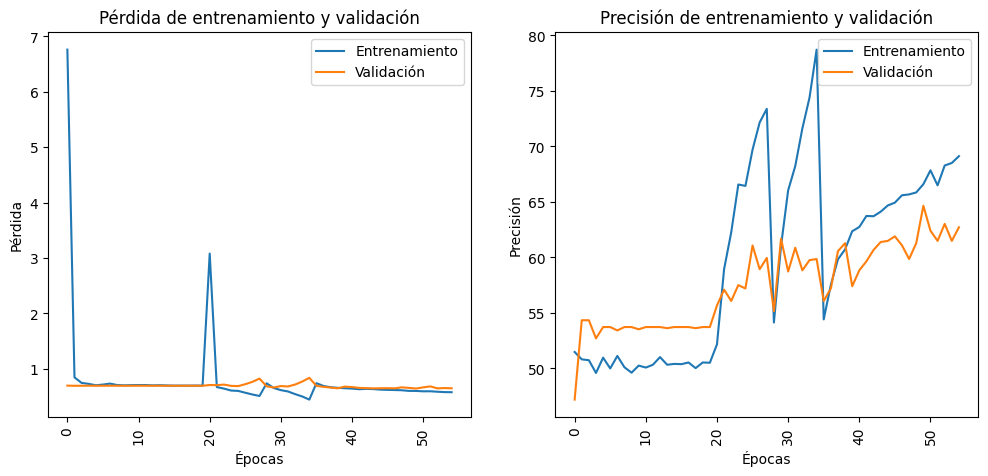

In [48]:
plt.figure(figsize=(12,5))

# Pérdida
plt.subplot(1,2,1)
plt.plot(train_losses,label='Entrenamiento')
plt.plot(val_losses,label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.xticks(rotation=90)
plt.title('Pérdida de entrenamiento y validación')
plt.legend()

# Precisión
plt.subplot(1,2,2)
plt.plot(train_accuracy,label='Entrenamiento')
plt.plot(val_accuracy,label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.xticks(rotation=90)
plt.title('Precisión de entrenamiento y validación')
plt.legend()

plt.show()